In [54]:
#!unzip drive/MyDrive/Pets-data/images.zip
#!cp -r drive/MyDrive/Pets-data/annotations .
#!ls

In [55]:
import os
import yaml
from typing import Tuple, List

import torch
import torch.nn.functional as F
import torchvision
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from pydantic import BaseModel
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import copy

In [56]:
# Define constants

CONFIG_FILE_PATH = 'config-mixmatch.yaml'
IMAGE_COL_IDX = 0
CLASS_ID_COL_IDX = 1
SPECIES_COL_IDX = 2
POSSIBLE_NUM_CLASSES = {2, 37}
T = 0.5

In [57]:
class AdamOptimizerConfig(BaseModel):
    lr: float
    weight_decay: float

In [58]:
class Config(BaseModel):
    device: str
    num_classes: int
    batch_size: int
    max_num_epochs: int
    patience: int
    adam_optimizer_config: AdamOptimizerConfig
    num_batch_norm_layers_to_train_params: int
    num_batch_norm_layers_to_update_running_stats: int
    train_earlier_layers_delay: int
    n_hidden_layers_to_train: int
    labelled_data_ratio: float
    ema_decay: float
    lambda_u_epoch_max: int
    alpha: float
    lambda_u: float

In [59]:
with open(CONFIG_FILE_PATH, encoding='utf-8') as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)

config = Config.model_validate(config_dict)

assert config.num_classes in POSSIBLE_NUM_CLASSES
assert 0 <= config.num_batch_norm_layers_to_train_params <= 36  # 36 batch norm layers in resnet34
assert 0 <= config.num_batch_norm_layers_to_update_running_stats <= 36  # 36 batch norm layers in resnet34

In [60]:
# K = 2
class TransformTwice(nn.Module):
    def __init__(self, transformation):
        super().__init__()
        self.transformation = transformation

    def __call__(self, data):
        return self.transformation(data), self.transformation(data)

In [61]:
class LabelledImageDataset(Dataset):
    def __init__(self, filenames: List[str], labels: List[int], use_augmentations: bool) -> None:
        self.filenames = filenames
        self.labels = labels
        # self.transformation = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        self.transformation = (
            transforms.Compose([
                torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms(),
                #transforms.RandomCrop((what size, what other size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10, 10)),
                #transforms.RandomErasing(),
            ])
            if use_augmentations
            else torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        )

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(os.path.join('images', f'{self.filenames[idx]}.jpg')).convert('RGB')
        label = self.labels[idx]

        transformed_img = self.transformation(image)

        return transformed_img.to(config.device), torch.tensor(label).to(config.device)

In [62]:
class UnlabelledImageDataset(Dataset):
    def __init__(self, filenames: List[str], use_augmentations: bool) -> None:
        self.filenames = filenames
        # self.transformation = torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        self.transformation = (
            transforms.Compose([
                torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms(),
                # transforms.RandomCrop((what size, what other size)),
                TransformTwice(
                    nn.Sequential(
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation((-10, 10))
                        )
                    ),
                # transforms.RandomRotation((-10, 10)),
                # transforms.RandomErasing(),
            ])
            if use_augmentations
            else torchvision.models.ResNet34_Weights.IMAGENET1K_V1.transforms()
        )

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(os.path.join('images', f'{self.filenames[idx]}.jpg')).convert('RGB')

        transformed_img, transformed_img_2 = self.transformation(image)

        return transformed_img.to(config.device), transformed_img_2.to(config.device)

In [63]:
def get_image_names_and_labels(annotations_file_path: str, num_classes: int) -> Tuple[List[str], List[int]]:
    filenames: List[str] = []
    labels: List[int] = []

    with open(annotations_file_path, encoding='utf-8') as f:
        lines = f.readlines()

    label_col_idx = SPECIES_COL_IDX if num_classes == 2 else CLASS_ID_COL_IDX

    for line in lines:
        line_split = line.split()
        filenames.append(line_split[IMAGE_COL_IDX])
        labels.append(int(line_split[label_col_idx]) - 1)

    return filenames, labels

In [64]:
def get_batch_norm_layers(model: nn.Module) -> List[nn.Module]:
    return [
        module
        for module in model.modules()
        if isinstance(module, nn.BatchNorm2d)
    ]

In [65]:
def get_pretrained_model_with_trainable_last_layer(num_batch_norm_layers_to_train_params: int) -> nn.Module:
    model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    batch_norm_layers = get_batch_norm_layers(model)
    batch_norm_layers_to_train_params = batch_norm_layers[-num_batch_norm_layers_to_train_params:] if num_batch_norm_layers_to_train_params else []

    for batch_norm_layer in batch_norm_layers_to_train_params:
        for param in batch_norm_layer.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=config.num_classes)

    return model.to(config.device)

In [66]:
def make_hidden_layers_trainable(model: nn.Module, number_of_hidden_layers_to_train: int) -> nn.Module:
    trainable_layers = [layer for layer in model.modules() if not isinstance(layer, torchvision.models.resnet.ResNet) and not isinstance(layer, torchvision.models.resnet.BasicBlock) and not isinstance(layer, nn.Sequential) and not isinstance(layer, nn.Sequential) and len(list(layer.parameters())) > 0]
    trainable_layers = list(reversed(trainable_layers[:-1]))

    for l in trainable_layers[:number_of_hidden_layers_to_train]:
        for p in l.parameters():
            p.requires_grad = True

    return model

In [67]:
def get_model_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    correct_predictions_cnt = 0
    total_predictions_cnt = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Computing accuracy'):
            outputs = model(inputs)
            correct_predictions_cnt += (torch.argmax(outputs, axis=1) == labels).sum()
            total_predictions_cnt += len(outputs)
    return correct_predictions_cnt / total_predictions_cnt

In [68]:
def mix_up(X_1, X_2, Y_1, Y_2):
    assert X_1.shape == X_2.shape, 'mix_up: inputs must have same size'
    X = []
    Y = []
    for i in range(len(X_1)):
        x_1 = X_1[i]
        x_2 = X_2[i]
        y_1 = Y_1[i]
        y_2 = Y_2[i]
        l = np.random.beta(config.alpha, config.alpha)
        l = max(l, (1-l))
        x = l * x_1 + (1-l) * x_2
        y = l * y_1 + (1-l) * y_2

        X.append(x)
        Y.append(y)
    return torch.stack(X), torch.stack(Y)

In [69]:
def linear_rampup(epoch):
    return float(min(epoch / config.lambda_u_epoch_max, 1))

In [70]:
class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, config.lambda_u * linear_rampup(epoch)

In [71]:
def update_ema_parameters(model, ema_model, ema_decay=0.999):
    with torch.no_grad():
        for ema_param, param in zip(ema_model.parameters(), model.parameters()):
            ema_param.data.copy_(ema_param.data * ema_decay + (1 - ema_decay) * param.data)

In [72]:
def infinite_batch_generator(loader: DataLoader):
    while True:
        for batch in loader:
            yield batch


def train_single_epoch(
        model: nn.Module,
        ema_model: nn.Module,        
        train_data_loader: DataLoader,
        unlabelled_train_data_loader: DataLoader,
        criterion: SemiLoss,
        optimizer: torch.optim.Optimizer,
        num_batch_norm_layers_to_update_running_stats: int,
        epoch: int,
        ) -> float:
    model.train()
    batch_norm_layers = get_batch_norm_layers(model)
    batch_norm_layers_to_not_update_running_stats = (
        batch_norm_layers[:-num_batch_norm_layers_to_update_running_stats]
        if num_batch_norm_layers_to_update_running_stats
        else batch_norm_layers
    )
    for batch_norm_layer in batch_norm_layers_to_not_update_running_stats:
        batch_norm_layer.eval()
    train_loss_sum = 0.0
    train_samples_cnt = 0

    unlabelled_generator = infinite_batch_generator(unlabelled_train_data_loader)

    for labelled_inputs, labelled_targets in tqdm(train_data_loader, desc='Training model'):

        labelled_targets = F.one_hot(labelled_targets, config.num_classes)
        unlabelled_inputs_1, unlabelled_inputs_2 = next(unlabelled_generator)
        unlabelled_inputs = torch.cat([unlabelled_inputs_1, unlabelled_inputs_2])

        # Calculated the pseudo label for each of the augmented unlabeled data point
        with torch.no_grad():
            u_o_1 = model(unlabelled_inputs_1)
            u_o_2 = model(unlabelled_inputs_2)
            unlabelled_targets = (F.softmax(u_o_1, dim=1) + F.softmax(u_o_2, dim=1)) / 2
            unlabelled_targets = unlabelled_targets**(1/T)
            unlabelled_targets = unlabelled_targets / unlabelled_targets.sum(dim=1, keepdim=True)

        all_inputs = torch.cat([labelled_inputs, unlabelled_inputs_1, unlabelled_inputs_2])
        all_targets = torch.cat([labelled_targets, unlabelled_targets, unlabelled_targets])
        idxs = np.random.permutation(len(all_inputs))
        all_inputs = all_inputs[idxs]
        all_targets = all_targets[idxs]

        X, targets_X = mix_up(labelled_inputs, all_inputs[:len(labelled_inputs)], labelled_targets, all_targets[:len(labelled_inputs)])
        U, targets_U = mix_up(unlabelled_inputs, all_inputs[len(labelled_inputs):], torch.cat([unlabelled_targets, unlabelled_targets]), all_targets[len(labelled_inputs):])

        outputs_X = model(X)
        outputs_U = model(U)

        LX, LU, lamb_u = criterion(outputs_X, targets_X, outputs_U, targets_U, epoch)

        optimizer.zero_grad()
        loss = LX + lamb_u * LU
        loss.backward()
        optimizer.step()
        update_ema_parameters(model, ema_model, config.ema_decay)
        train_loss_sum += loss.item() * (len(outputs_X) + len(outputs_U))
        train_samples_cnt += len(outputs_X) + len(outputs_U)

    return train_loss_sum / train_samples_cnt

In [73]:
def save_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer) -> Tuple[nn.Module, torch.optim.Optimizer]:
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, 'checkpoint.pt')

In [74]:
def load_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer) -> None:
    checkpoint = torch.load('checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [75]:
filenames_trainval, labels_trainval = get_image_names_and_labels('annotations/trainval.txt', num_classes=config.num_classes)
filenames_test, labels_test = get_image_names_and_labels('annotations/test.txt', num_classes=config.num_classes)
filenames_train, filenames_val, labels_train, labels_val = train_test_split(filenames_trainval, labels_trainval, test_size=0.2, stratify=labels_trainval)

filenames_train, unlabelled_filenames_train, labels_train, _ = train_test_split(filenames_train, labels_train, train_size=config.labelled_data_ratio, stratify=labels_train)
dataset_train = LabelledImageDataset(filenames_train, labels_train, use_augmentations=True)
unlabelled_dataset_train = UnlabelledImageDataset(unlabelled_filenames_train, use_augmentations=True)

dataset_val = LabelledImageDataset(filenames_val, labels_val, use_augmentations=False)
dataset_test = LabelledImageDataset(filenames_test, labels_test, use_augmentations=False)

unlabelled_train_data_loader = DataLoader(unlabelled_dataset_train, batch_size=config.batch_size, shuffle=True)
train_data_loader = DataLoader(dataset_train, batch_size=config.batch_size, shuffle=True)
val_data_loader = DataLoader(dataset_val, batch_size=config.batch_size, shuffle=False)
test_data_loader = DataLoader(dataset_test, batch_size=config.batch_size, shuffle=False)

In [76]:
# Train using pseudo labelling
def train_model():
    model = get_pretrained_model_with_trainable_last_layer(config.num_batch_norm_layers_to_train_params)
    ema_model = copy.deepcopy(model)

    criterion = SemiLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.adam_optimizer_config.lr, weight_decay=config.adam_optimizer_config.weight_decay)

    max_val_accuracy = float('-inf')
    argmax_epoch = -1

    accuracies = []

    for epoch in range(config.max_num_epochs):
        print(f'Epoch #{epoch}:')
        train_loss = train_single_epoch(model, ema_model, train_data_loader, unlabelled_train_data_loader, criterion, optimizer, config.num_batch_norm_layers_to_update_running_stats, epoch)
        print(f'Train loss: {train_loss}')
        val_accuracy = get_model_accuracy(ema_model, val_data_loader)
        accuracies.append(val_accuracy)
        if val_accuracy > max_val_accuracy:
            print(f'Validation accuracy: {100 * val_accuracy:.2f}% (new best)')
            max_val_accuracy = val_accuracy
            argmax_epoch = epoch
            save_checkpoint(ema_model, optimizer)
            print('Checkpoint saved')
        else:
            print(f'Validation accuracy: {100 * val_accuracy:.2f}% (worse than {100 * max_val_accuracy:.2f}% of epoch {argmax_epoch})')
            if epoch > argmax_epoch + config.patience:
                print(f'Early stopping')
                break
        # Start training earlier layers
        if epoch == config.train_earlier_layers_delay and config.n_hidden_layers_to_train > 0:
            print (f'Making last {config.n_hidden_layers_to_train} hidden layers trainable')
            make_hidden_layers_trainable(model, config.n_hidden_layers_to_train)
            optimizer = torch.optim.Adam(model.parameters(), lr=config.adam_optimizer_config.lr / 100, weight_decay=config.adam_optimizer_config.weight_decay)
        print()
    return ema_model, optimizer, accuracies

In [77]:
# Train the model
model, optimizer, accuracies = train_model()


Epoch #0:


Training model: 100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


Train loss: 3.674716577825948


Computing accuracy: 100%|██████████| 46/46 [00:08<00:00,  5.11it/s]


Validation accuracy: 2.85% (new best)
Checkpoint saved

Epoch #1:


Training model: 100%|██████████| 19/19 [00:23<00:00,  1.25s/it]


Train loss: 2.8135426002172568


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]


Validation accuracy: 3.12% (new best)
Checkpoint saved

Epoch #2:


Training model: 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


Train loss: 2.2728993057411686


Computing accuracy: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]


Validation accuracy: 3.40% (new best)
Checkpoint saved

Epoch #3:


Training model: 100%|██████████| 19/19 [00:23<00:00,  1.23s/it]


Train loss: 1.8081910380238704


Computing accuracy: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


Validation accuracy: 3.80% (new best)
Checkpoint saved

Epoch #4:


Training model: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Train loss: 1.600029920527253


Computing accuracy: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]


Validation accuracy: 4.48% (new best)
Checkpoint saved

Epoch #5:


Training model: 100%|██████████| 19/19 [00:24<00:00,  1.27s/it]


Train loss: 1.448958943794149


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.30it/s]


Validation accuracy: 5.03% (new best)
Checkpoint saved

Epoch #6:


Training model: 100%|██████████| 19/19 [00:23<00:00,  1.25s/it]


Train loss: 1.4413149822049025


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.43it/s]


Validation accuracy: 5.84% (new best)
Checkpoint saved

Epoch #7:


Training model: 100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


Train loss: 1.4213955015142319


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]


Validation accuracy: 7.07% (new best)
Checkpoint saved

Epoch #8:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.40s/it]


Train loss: 1.2664552509388216


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.22it/s]


Validation accuracy: 8.83% (new best)
Checkpoint saved

Epoch #9:


Training model: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


Train loss: 1.2429536488526676


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]


Validation accuracy: 10.19% (new best)
Checkpoint saved

Epoch #10:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.37s/it]


Train loss: 1.2528221065347844


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  3.99it/s]


Validation accuracy: 12.77% (new best)
Checkpoint saved

Epoch #11:


Training model: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Train loss: 1.2045215196461476


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]


Validation accuracy: 14.67% (new best)
Checkpoint saved

Epoch #12:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.39s/it]


Train loss: 1.1476788126972985


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s]


Validation accuracy: 16.98% (new best)
Checkpoint saved

Epoch #13:


Training model: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]


Train loss: 1.2241505802074186


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.56it/s]


Validation accuracy: 20.38% (new best)
Checkpoint saved

Epoch #14:


Training model: 100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


Train loss: 1.1825372070536646


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.61it/s]


Validation accuracy: 23.64% (new best)
Checkpoint saved

Epoch #15:


Training model: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]


Train loss: 1.1714645428562376


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]


Validation accuracy: 27.31% (new best)
Checkpoint saved

Epoch #16:


Training model: 100%|██████████| 19/19 [00:29<00:00,  1.57s/it]


Train loss: 1.1220555820909148


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]


Validation accuracy: 30.84% (new best)
Checkpoint saved

Epoch #17:


Training model: 100%|██████████| 19/19 [00:25<00:00,  1.35s/it]


Train loss: 1.1469220409372165


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.77it/s]


Validation accuracy: 34.38% (new best)
Checkpoint saved

Epoch #18:


Training model: 100%|██████████| 19/19 [00:27<00:00,  1.44s/it]


Train loss: 1.1393073933351858


Computing accuracy: 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


Validation accuracy: 37.23% (new best)
Checkpoint saved

Epoch #19:


Training model: 100%|██████████| 19/19 [00:25<00:00,  1.36s/it]


Train loss: 1.1534932151337685


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.52it/s]


Validation accuracy: 40.49% (new best)
Checkpoint saved

Epoch #20:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.41s/it]


Train loss: 1.1907894172583875


Computing accuracy: 100%|██████████| 46/46 [00:14<00:00,  3.13it/s]


Validation accuracy: 43.61% (new best)
Checkpoint saved

Epoch #21:


Training model: 100%|██████████| 19/19 [00:34<00:00,  1.80s/it]


Train loss: 1.2237793918195161


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


Validation accuracy: 47.28% (new best)
Checkpoint saved

Epoch #22:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.41s/it]


Train loss: 1.1291749584436945


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]


Validation accuracy: 49.46% (new best)
Checkpoint saved

Epoch #23:


Training model: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]


Train loss: 1.167141919918441


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.74it/s]


Validation accuracy: 52.45% (new best)
Checkpoint saved

Epoch #24:


Training model: 100%|██████████| 19/19 [00:34<00:00,  1.80s/it]


Train loss: 1.1928374608710177


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]


Validation accuracy: 55.57% (new best)
Checkpoint saved

Epoch #25:


Training model: 100%|██████████| 19/19 [00:28<00:00,  1.49s/it]


Train loss: 1.2037007170347311


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  4.09it/s]


Validation accuracy: 57.88% (new best)
Checkpoint saved

Epoch #26:


Training model: 100%|██████████| 19/19 [00:25<00:00,  1.35s/it]


Train loss: 1.2317662593266387


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s]


Validation accuracy: 59.92% (new best)
Checkpoint saved

Epoch #27:


Training model: 100%|██████████| 19/19 [00:30<00:00,  1.63s/it]


Train loss: 1.1224463342827333


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]


Validation accuracy: 62.23% (new best)
Checkpoint saved

Epoch #28:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.38s/it]


Train loss: 1.02513797478771


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.60it/s]


Validation accuracy: 64.13% (new best)
Checkpoint saved

Epoch #29:


Training model: 100%|██████████| 19/19 [00:27<00:00,  1.46s/it]


Train loss: 1.2667454364823132


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


Validation accuracy: 66.03% (new best)
Checkpoint saved

Epoch #30:


Training model: 100%|██████████| 19/19 [00:29<00:00,  1.57s/it]


Train loss: 1.1506858606824855


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  3.98it/s]


Validation accuracy: 69.02% (new best)
Checkpoint saved

Epoch #31:


Training model: 100%|██████████| 19/19 [00:28<00:00,  1.49s/it]


Train loss: 1.0461428236802772


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.64it/s]


Validation accuracy: 71.47% (new best)
Checkpoint saved

Epoch #32:


Training model: 100%|██████████| 19/19 [00:27<00:00,  1.46s/it]


Train loss: 1.1996969444524423


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]


Validation accuracy: 72.69% (new best)
Checkpoint saved

Epoch #33:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.38s/it]


Train loss: 1.1356887428829252


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s]


Validation accuracy: 73.91% (new best)
Checkpoint saved

Epoch #34:


Training model: 100%|██████████| 19/19 [00:30<00:00,  1.60s/it]


Train loss: 1.1192344466757087


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  3.90it/s]


Validation accuracy: 74.73% (new best)
Checkpoint saved

Epoch #35:


Training model: 100%|██████████| 19/19 [00:27<00:00,  1.44s/it]


Train loss: 1.2504803954629835


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  3.97it/s]


Validation accuracy: 76.36% (new best)
Checkpoint saved

Epoch #36:


Training model: 100%|██████████| 19/19 [00:27<00:00,  1.42s/it]


Train loss: 1.1890991856147868


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.76it/s]


Validation accuracy: 76.77% (new best)
Checkpoint saved

Epoch #37:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.40s/it]


Train loss: 1.060727167420271


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  3.89it/s]


Validation accuracy: 77.17% (new best)
Checkpoint saved

Epoch #38:


Training model: 100%|██████████| 19/19 [00:28<00:00,  1.50s/it]


Train loss: 1.0797834585352641


Computing accuracy: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


Validation accuracy: 78.26% (new best)
Checkpoint saved

Epoch #39:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.38s/it]


Train loss: 1.1115143388972315


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s]


Validation accuracy: 78.67% (new best)
Checkpoint saved

Epoch #40:


Training model: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


Train loss: 1.0694398955336695


Computing accuracy: 100%|██████████| 46/46 [00:11<00:00,  4.01it/s]


Validation accuracy: 79.35% (new best)
Checkpoint saved

Epoch #41:


Training model: 100%|██████████| 19/19 [00:25<00:00,  1.37s/it]


Train loss: 1.1514119985626965


Computing accuracy: 100%|██████████| 46/46 [00:12<00:00,  3.57it/s]


Validation accuracy: 80.16% (new best)
Checkpoint saved

Epoch #42:


Training model: 100%|██████████| 19/19 [00:26<00:00,  1.39s/it]


Train loss: 1.0713632199293759


Computing accuracy: 100%|██████████| 46/46 [00:13<00:00,  3.33it/s]


Validation accuracy: 80.84% (new best)
Checkpoint saved

Epoch #43:


Training model:  42%|████▏     | 8/19 [00:26<00:36,  3.28s/it]


KeyboardInterrupt: 

NameError: name 'accuracies' is not defined

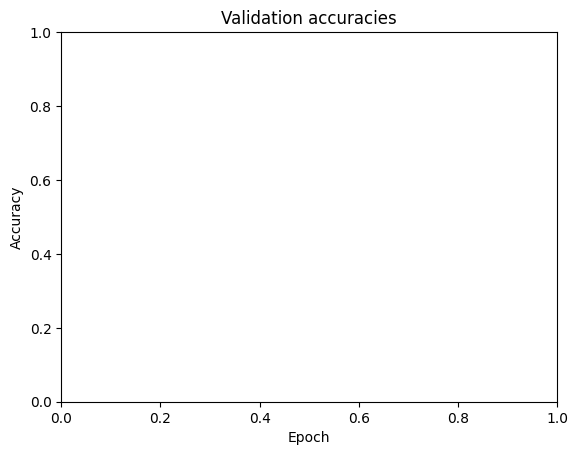

In [ ]:
plt.title('Validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(torch.tensor(accuracies).cpu().numpy())

plt.show()

In [ ]:
model = get_pretrained_model_with_trainable_last_layer(0)
optimizer = torch.optim.Adam(model.parameters(), lr=config.adam_optimizer_config.lr, weight_decay=config.adam_optimizer_config.weight_decay)
load_checkpoint(model, optimizer)
print('Checkpoint loaded')

test_accuracy = get_model_accuracy(model, test_data_loader)

print(f'Test accuracy: {100 * test_accuracy:.4f}%')

Checkpoint loaded


Computing accuracy: 100%|█████████▉| 229/230 [01:31<00:00,  1.38it/s]c:\Users\stein\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Computing accuracy: 100%|██████████| 230/230 [01:32<00:00,  2.48it/s]


Test accuracy: 87.05%
